In [1]:
import pandas as pd
import numpy as np
import math
import datetime

from A320 import *
from Constants import *
from ISA_Functions import *
from Job_input import *

In [2]:
#Gridデータ作成
print("imin=",imin,"xmin=",xmin,"/ imax=",imax,"xmax=",xmax,"km")
print("jmin=",jmin,"ymin=",ymin,"/ jmax=",jmax,"ymax=",ymax,"km")
print("kmin=",kmin,"zmin=",zmin,"/ kmax=",kmax,"zmax=",zmax,"m")
print("lmin=",lmin,"vmin=",cas2tas(vmin,zmin),"/ lmax=",lmax,"vmax=",cas2tas(vmax,zmax),"m/s")

#配列定義
x=np.zeros((imax+1,jmax+1,kmax+1,lmax+1)) #[km]
y=np.zeros((imax+1,jmax+1,kmax+1,lmax+1)) #[km]
z=np.zeros((imax+1,jmax+1,kmax+1,lmax+1)) #[m]
vcas=np.zeros((imax+1,jmax+1,kmax+1,lmax+1)) #[CAS_m/s]
v=np.zeros((imax+1,jmax+1,kmax+1,lmax+1)) #[TAS_m/s]

for i in range(imin, imax+1):
    for j in range(jmin, jmax+1):
        for k in range(kmin,kmax+1):
            for l in range(lmin,lmax+1):
                x[i][j][k][l]=xmin+Delta_x*(i-imin) #[km]
                z[i][j][k][l]=zmin+Delta_z*(k-kmin) #[m]
                vcas[i][j][k][l]=vmin+Delta_v*(l-lmin) #[CAS_m/s]
                v[i][j][k][l]=cas2tas(vcas[i][j][k][l],z[i][j][k][l]) #[TAS_m/s]

#速度制限がVMOかMMOかの仕分け
M_vcas_trans=np.zeros((imax+1,jmax+1,kmax+1,lmax+1), dtype=np.bool) #Mach数評定の場合True

for i in range(imin, imax+1):
    for j in range(jmin, jmax+1):
        for k in range(kmin,kmax+1):
            for l in range(lmin,lmax+1):
                x_cur=x[i][j][k][l] #ダウンレンジ
                z_cur=z[i][j][k][l] #圧力高度
                vcas_cur=vcas[i][j][k][l] #補正対気速度
                T_cur=Alt2Temp(z_cur) #[K]温度
                p_cur=Alt2Press(z_cur) #[Pa]気圧
                rho_cur=Alt2Dens(z_cur) #[kg/m3]密度
                a_cur=np.sqrt(gamma*R*T_cur) #[m/s]音速
                v_cur=cas2tas(vcas_cur,z_cur) #[m/s]真対気速度
                Mach_cur=v_cur/a_cur #Mach数
                
                p_trans=p0*((1+(gamma-1)/2*(vcas_cur/a0)**2)**(1/mu)-1)/((1+(gamma-1)/2*Mach_cur**2)**(1/mu)-1) #[Pa]
                
                if p_trans>=p_trop:
                    z_trans=T0/betaT*((p_trans/p0)**(-betaT*R/g0)-1) #[m]
                else:
                    z_trans=z_trop-R*T_trop/g0*math.log(p_trans/p_trop) #[m]
                    
                if z_trans>=z_cur:
                    M_vcas_trans[i][j][k][l]=False #CAS評定
                else:
                    M_vcas_trans[i][j][k][l]=True #Mach数評定

imin= 0 xmin= 0.0 / imax= 40 xmax= 800.0 km
jmin= 0 ymin= 0.0 / jmax= 0 ymax= 0.0 km
kmin= 0 zmin= 3657.6000000000004 / kmax= 56 zmax= 12192.0 m
lmin= 0 vmin= 177.8779492342834 / lmax= 30 vmax= 324.48130525047253 m/s


In [3]:
#初期条件
print("i_start=",i_start,"x=",x[i_start][j_start][k_start][l_start],"km")
print("k_start=",k_start,"z=",z[i_start][j_start][k_start][l_start],"m")
print("l_start=",l_start,"vcas=",vcas[i_start][j_start][k_start][l_start],"CAS_m/s")
print("l_start=",l_start,"vtas=",v[i_start][j_start][k_start][l_start],"TCAS_m/s")
print("i_end=",i_end,"x=",x[i_end][j_end][k_end][l_end],"km")
print("k_end=",k_end,"z=",z[i_end][j_end][k_end][l_end],"m")
print("l_end=",l_end,"vcas=",vcas[i_end][j_end][k_end][l_end],"CAS_m/s")
print("l_end=",l_end,"vtas=",v[i_end][j_end][k_end][l_end],"TCAS_m/s")

i_start= 0 x= 0.0 km
k_start= 0 z= 3657.6000000000004 m
l_start= 10 vcas= 160.0 CAS_m/s
l_start= 10 vtas= 189.43295408851674 TCAS_m/s
i_end= 40 x= 800.0 km
k_end= 0 z= 3657.6000000000004 m
l_end= 10 vcas= 160.0 CAS_m/s
l_end= 10 vtas= 189.43295408851674 TCAS_m/s


In [4]:
#有効接点識別タグ
Effective_Node=np.zeros((imax+1,jmax+1,kmax+1,lmax+1), dtype=np.bool)

#親接点の格納配列にかかる相対位置
Previous_Node_i=np.zeros((imax+1,jmax+1,kmax+1,lmax+1), dtype=np.int)
Previous_Node_j=np.zeros((imax+1,jmax+1,kmax+1,lmax+1), dtype=np.int)
Previous_Node_k=np.zeros((imax+1,jmax+1,kmax+1,lmax+1), dtype=np.int)
Previous_Node_l=np.zeros((imax+1,jmax+1,kmax+1,lmax+1), dtype=np.int)

#重量配列
W=np.zeros((imax+1,jmax+1,kmax+1,lmax+1), dtype=np.float) #[kg]

#iminにおいて始点ノードのみ有効化
Effective_Node[i_start][j_start][k_start][l_start]=True
W[i_start][j_start][k_start][l_start]=m_start*1000 #[kg] 始点ノードにおける重量を指定

#imaxにおいて終点ノードのみ有効化
Effective_Node[i_end][j_end][k_end][l_end]=True

#zz=zmax #z1縺ｨ譛繧りｿ代＞繝弱・繝峨→縺ｮ霍晞屬\n",
#vv=vmax #v_tas1縺ｨ譛繧りｿ代＞繝弱・繝峨→縺ｮ騾溷ｺｦ蟾ｮ\n",

#kk=kmax
#ll=lmax

#for k in range(kmin, kmax+1):
#    for l in range(lmin,lmax+1):
#        if abs(z[imin][jmin][k][l]-z1)<=zz:
#            if abs(vcas[imin][jmin][k][l]-v_cas1)<=vv:
#                zz=abs(z[imin][jmin][k][l]-z1) #[m]
#                vv=abs(vcas[imin][jmin][k][l]-v_cas1) #[m/s]
#                Effective_Node[imin][jmin][k][l]=True
#                Effective_Node[imin][jmin][kk][ll]=False
#                W[imin][jmin][kk][ll]=0
#                W[imin][jmin][k][l]=mref*1000 #[kg]
#                kk=k
#                ll=l

#print(kk,ll,zz,vv)
#print(z[imin][jmin][kk][ll],vcas[imin][jmin][kk][ll])
#print(Effective_Node[imin][jmin][kk][ll-1],W[imin][jmin][kk][ll-1])
#print(Effective_Node[imin][jmin][kk][ll],W[imin][jmin][kk][ll])
#print(Effective_Node[imin][jmin][kk][ll+1],W[imin][jmin][kk][ll+1])
#print(Effective_Node[imin][jmin][kk-1][ll],W[imin][jmin][kk-1][ll])
#print(Effective_Node[imin][jmin][kk+1][ll],W[imin][jmin][kk+1][ll])

#蛻ｰ逹菴咲ｽｮ\n",
#zz=zmax
#vv=vmax
#kk=kmax
#ll=lmax

#for k in range(kmin, kmax+1):
#    for l in range(lmin,lmax+1):
#        if abs(z[imax][jmax][k][l]-z2)<=zz:
#            if abs(vcas[imax][jmax][k][l]-v_cas2)<=vv:
#                zz=abs(z[imax][jmax][k][l]-z2)
#                vv=abs(vcas[imax][jmax][k][l]-v_cas2)
#                Effective_Node[imax][jmax][k][l]=True
#                Effective_Node[imax][jmax][kk][ll]=False
#                kk=k
#                ll=l

#print(kk,ll,zz,vv)
#print(z[imax][jmax][kk][ll],vcas[imax][jmax][kk][ll])
#print(Effective_Node[imax][jmax][kk][ll-1])
#print(Effective_Node[imax][jmax][kk][ll])
#print(Effective_Node[imax][jmax][kk][ll+1])
#print(Effective_Node[imax][jmax][kk-1][ll])
#print(Effective_Node[imax][jmax][kk+1][ll])

In [5]:
#コスト配列
#Fuel_Burn = np.full((imax+1,jmax+1,kmax+1,lmax+1),99999.9)
Flight_Time = np.zeros((imax+1,jmax+1,kmax+1,lmax+1)) #[sec] 飛行時間累積
Fuel_Burn = np.zeros((imax+1,jmax+1,kmax+1,lmax+1)) #[kg] 燃料消費累積
Flight_Quality = np.zeros((imax+1,jmax+1,kmax+1,lmax+1)) #[max_m/s] 機体動揺最大値

In [11]:
#最適経路探索ルーチン
#X方向にiを順にインクリメントしていく
#X方向に、ID=iのInitial接点とi+1のFinal接点の組み合わせに対し…
#接点間の高度/速度からコストを算出、コストミニマムとする経路を選定
#for i in range(imin, imax-1):
for i in range(imin, imax):
    print("i=",i)
    for j in range(jmin, jmax+1):
        for k in range(kmin,kmax+1):
            for l in range(lmin,lmax+1):
                if Effective_Node[i][j][k][l]==True: #有効なInitial接点の場合、コストを算出する
                    x_init=x[i][j][k][l] #[km]
                    y_init=y[i][j][k][l] #[km]
                    z_init=z[i][j][k][l] #[m]
                    W_init=W[i][j][k][l] #[kg]
                    v_init=v[i][j][k][l] #[TAS_m/s]
                    T_init=Alt2Temp(z_init) #[K]
                    p_init=Alt2Press(z_init) #[Pa]
                    rho_init=Alt2Dens(z_init) #[kg/m3]
                    vcas_init=vcas[i][j][k][l] #[CAS_m/s]
                    a_init=np.sqrt(gamma*R*T_init) #[m/s]
                    Mach_init=v_init/a_init
                    q_init=0.5*rho_init*v_init**2 #[Pa] 動圧@出発点
                    CL_init=W_init*g0/q_init/Sref #揚力係数@出発点
                    CD_init=CD0_CR+CD2_CR*CL_init**2 #抵抗係数@出発点
                    Drag_init=CD_init*q_init*Sref
#                    print("♪♪♪♪♪♪♪♪♪♪","k_init=",k,"l_init=",l,"W=",W_init,"TAS=",v_init,"CAS=",vcas_init,"Mach=",Mach_init,"CL1=",CL_init,"CD1=",CD_init,"Drag1=",Drag_init)
                    for jj in range(jmin, jmax+1):
                        for kk in range(kmin,kmax+1):
                            for ll in range(lmin,lmax+1):
                                #print("Final Node",i+1,jj,kk,ll)
                                x_fin=x[i+1][jj][kk][ll] #[km]
                                y_fin=y[i+1][jj][kk][ll] #[km]
                                z_fin=z[i+1][jj][kk][ll] #[m]
                                v_fin=v[i+1][jj][kk][ll] #[TAS_m/s]
                                T_fin=Alt2Temp(z_fin) #[K]
                                p_fin=Alt2Press(z_fin) #[Pa]
                                rho_fin=Alt2Dens(z_fin) #[kg/m3]
                                vcas_fin=vcas[i+1][jj][kk][ll] #[CAS_m/s]
                                a_fin=np.sqrt(gamma*R*T_fin) #[m/s]
                                Mach_fin=v_fin/a_fin
                                q_fin=0.5*rho_fin*v_fin**2 #[Pa] 動圧@到着点
                                M_vcas_fin=M_vcas_trans[i+1][jj][kk][ll] #最大速度制限の評定(Trueのときマッハ数)
                                
                                #始点、終点の接点における諸量の算出完了
                                
                                #接点間距離
                                Distance = np.sqrt(((x_init-x_fin)*1000)**2+((y_init-y_fin)*1000)**2+(z_init-z_fin)**2) #[m] 距離
                                #print(Distance,"m")
                                #接点間飛行時間（等加速度と仮定）
                                Time_sec=2*Distance/(v_init+v_fin) #[sec]
                                Time_min=Time_sec*sec2min #[min]
                                #print(Time_min,"min")
                                #加速度
                                Accel=(v_fin**2-v_init**2)/(2*Distance) #[m/s2]
                                
                                #必要推力
                                ccc=Cf1/1000*(1+((v_init+v_fin)*0.5*mps2kt)/Cf2)*Time_min #[kg/N]
                                aa=CD2_CR*g0**2*ccc**2/q_fin/Sref
                                bb=-(2+2*CD2_CR*g0**2*W_init*ccc/q_fin/Sref+ccc*v_fin**2/Distance+2*ccc*g0*z_fin/Distance)
                                cc=CD0_CR*q_init*Sref+CD2_CR*W_init**2*g0**2/q_init/Sref+CD0_CR*q_fin*Sref+CD2_CR*g0**2*W_init**2/q_fin/Sref+W_init*(v_fin**2-v_init**2+2*g0*(z_fin-z_init))/Distance

                                Thr1=(-bb+np.sqrt(bb**2-4*aa*cc))/(2*aa) #[kN]
                                Thr2=(-bb-np.sqrt(bb**2-4*aa*cc))/(2*aa) #[kN]
                                
                                #最大推力（常時）
                                Thr_max_climb=(CTC1*(1-(z_fin*m2ft)/CTC2+CTC3*(z_fin*m2ft)**2))*CTcr
#                                print("Max Thrust=",Thr_max_climb)
                                
                                #降下時推力
                                if z_init<Hpdes*m2ft:
                                    Thr_des=Thr_max_climb*CTdes_low
                                else:
                                    Thr_des=Thr_max_climb*CTdes_high
#                                print("Thrust_nominal=",Thr2,"N"," Thrust_descent=",Thr_des,"N")
                                Thr=max(Thr2,Thr_des)
                                
                                #燃料消費
                                Fuel_Consumption_nom=Thr2*ccc #[kg] 必要推力を使用した場合の消費燃料
                                Fuel_Consumption_des=Cf3*(1-(z_init+z_fin)*0.5*m2ft/Cf4)*Time_min #[kg] 推力に余力がある場合(アイドル)の消費燃料
                                
                                Fuel_Consumption=max(Fuel_Consumption_nom,Fuel_Consumption_des) #[kg] 燃料消費は、大きい方の値
#                                print("Fuel Consumption=",Fuel_Consumption_nom,Fuel_Consumption_des)
                                
#                                print("♪♪♪♪♪♪♪♪♪♪　k_fin=",kk,"l_fin=",ll,"W_fin=",W[i+1][jj][kk][ll],"TAS_fin=",v_fin,"CAS_fin=",vcas_fin)
                                
                                W_fin=W_init-Fuel_Consumption
                                CL_fin=W_fin*g0/q_fin/Sref #揚力係数@到着点
                                CD_fin=CD0_CR+CD2_CR*CL_fin**2 #抵抗係数@到着点
                                Drag_fin=CD_fin*q_fin*Sref
                                
#                                print("Ed1=",0.5*W_init*g0*v_init**2,"Ed2=",0.5*W_fin*g0*v_fin**2,"Delta_Ed=",0.5*W_fin*g0*v_fin**2-0.5*W_init*g0*v_init**2)
#                                print("Ep1=",W_init*g0*z_init,"Ep2=",W_fin*g0*z_fin,"Delta_Ep=",W_fin*g0*z_fin-W_init*g0*z_init)
                                
#                                print("Drag=",0.5*(Drag_init+Drag_fin),"Drag1=",Drag_init,"Drag2=",Drag_fin,"N")
#                                print("Thrust=",Thr,"N")
#                                print((Thr-0.5*(Drag_init+Drag_fin))*Distance,"Nm")
                                
                                #最適経路を判定
                                if Thr_max_climb>=Thr: #搭載エンジンによりこの高度まで上昇可能
#                                    print("OK: Less than Max Thrust"," CAS=",vcas_fin,"V_stall=",Vstall_CR)
                                    if vcas_fin>=Vstall_CR: #失速速度以上
#                                        print("OK: more than Stall speed.")
                                        if ((M_vcas_fin==True)and(Mach_fin<MMO))or((M_vcas_fin==False)and(vcas_fin<VMO)): #速度制限以下
#                                            print("OK: Less than maximum speed constraint") #この場合、次の接点まで飛行化可能
#                                            print("Weight=",W[i+1][jj][kk][ll],W_init-Fuel_Consumption)
                                            if W[i+1][jj][kk][ll]<W_init-Fuel_Consumption: #この場合が、最小燃料消費（機体重量最大）の可能性あり
#                                                print("OK: May be optimum path",k,l,"->",kk,ll,)
                                                Effective_Node[i+1][jj][kk][ll] = True
                                                W[i+1][jj][kk][ll]=W_init-Fuel_Consumption #[kg]
                                                Flight_Time[i+1][jj][kk][ll]=Flight_Time[i][j][k][l]+Time_sec #[sec]
                                                Fuel_Burn[i+1][jj][kk][ll]=Fuel_Burn[i][j][k][l]+Fuel_Consumption #[kg]
                                                Previous_Node_i[i+1][jj][kk][ll]=i-(i+1)
                                                Previous_Node_j[i+1][jj][kk][ll]=j-jj
                                                Previous_Node_k[i+1][jj][kk][ll]=k-kk
                                                Previous_Node_l[i+1][jj][kk][ll]=l-ll
#                                                print("★New optimum path is found!",kk,"z_fin=",z_fin,ll,"vcas_fin",vcas_fin,"  W=",W_init-Fuel_Consumption)
#                                            else:
#                                                print("☆Not optimum path")
#                                        else:
#                                            print("☆Over speed")
#                                    else:
#                                        print("☆Stall")
#                                else:
#                                    print("☆Over Maximun thrust")

i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39


In [12]:
print(W[i_end][j_end][k_end][l_end])
print(W[i_start][j_start][k_start][l_start])

275575.82263924065
284335.0


In [13]:
np.savez('v2dpo3',x,y,z,v,vcas,W,Flight_Time,Fuel_Burn,Flight_Quality,Previous_Node_i,Previous_Node_j,Previous_Node_k,Previous_Node_l,Effective_Node)

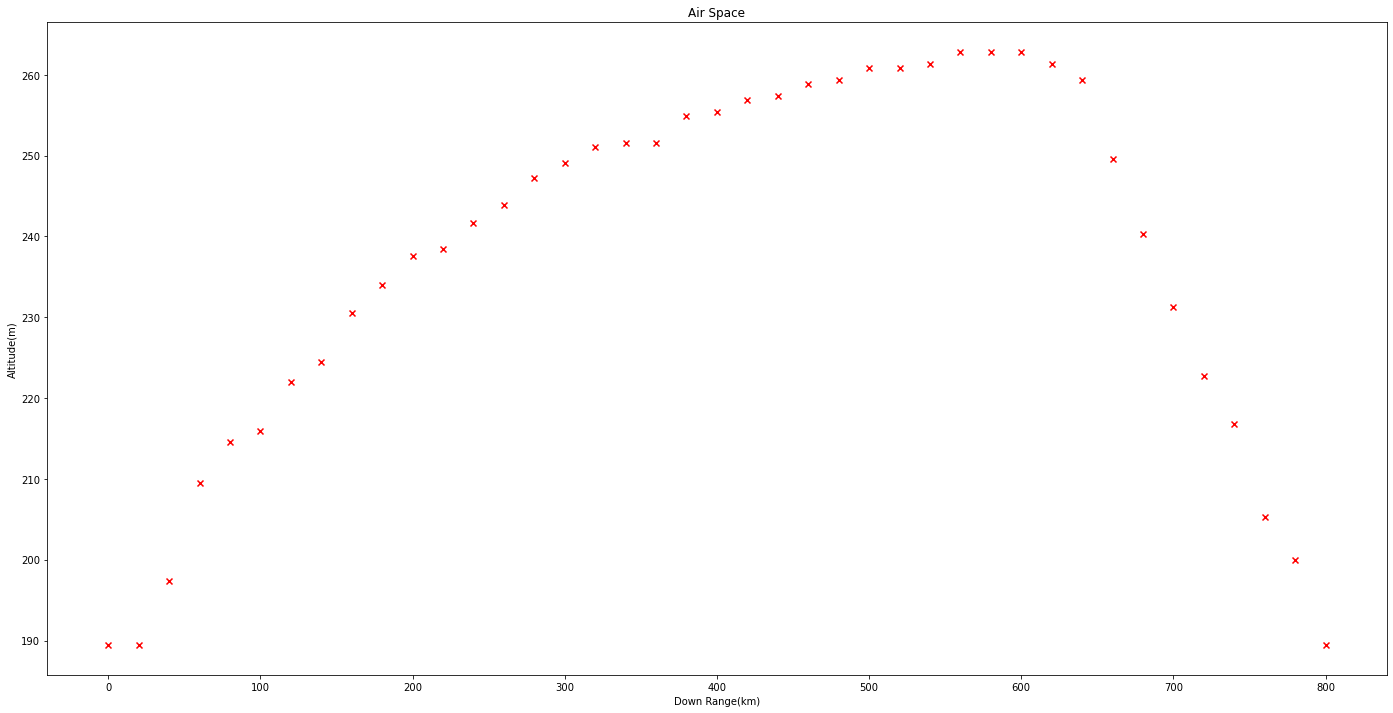

In [14]:
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(24, 12))
ax1 = fig1.add_subplot(111)
plt.title("Air Space")
plt.xlabel("Down Range(km)")
plt.ylabel("Altitude(m)")

#for i in range(imin,imax+1):
#    for k in range(kmin,kmax+1):
        #np.where(M_vcas_trans[i][jmin][k][lmin],ax1.scatter(x[i][jmin][k][lmax],z[i][jmin][k][lmax],color='b',marker=\"x\")
        #ax1.scatter(x[i][jmin][k][lmax],z[i][jmin][k][lmax],color='r',marker=\"x\"))
#        ax1.scatter(x[i][jmin][k][lmin],z[i][jmin][k][lmin],color='b',marker="x")

path_x=np.zeros(imax+1, dtype=np.float)
path_y=np.zeros(imax+1, dtype=np.float)
path_z=np.zeros(imax+1, dtype=np.float)
path_v=np.zeros(imax+1, dtype=np.float)
path_vcas=np.zeros(imax+1, dtype=np.float)
path_W=np.zeros(imax+1, dtype=np.float)

ipn=i_end
jpn=j_end
kpn=k_end
lpn=l_end

for i in range(imin,imax+1):
    path_x[i]=x[ipn][jpn][kpn][lpn]
    path_y[i]=y[ipn][jpn][kpn][lpn]
    path_z[i]=z[ipn][jpn][kpn][lpn]
    path_v[i]=v[ipn][jpn][kpn][lpn]
    path_vcas[i]=vcas[ipn][jpn][kpn][lpn]
    path_W[i]=W[ipn][jpn][kpn][lpn]
    
    ipn=ipn+Previous_Node_i[ipn][jpn][kpn][lpn]
    jpn=jpn+Previous_Node_j[ipn][jpn][kpn][lpn]
    kpn=kpn+Previous_Node_k[ipn][jpn][kpn][lpn]
    lpn=lpn+Previous_Node_l[ipn][jpn][kpn][lpn]
    
    ax1.scatter(path_x[i],path_v[i],color='r',marker="x")

plt.show()

In [ ]:
np.savez('v2dpo3',x,y,z,v,vcas,W,Flight_Tim,Fuel_Burn,Flight_Quality,path_x,path_y,path_z,path_v,path_W)

In [ ]:
                                if z_init<z_fin: #上昇するケース
                                    print("Climb Case")
                                    Thr_max_climb=(CTC1*(1-(z_fin*m2ft)/CTC2+CTC3*(z_fin*m2ft)**2))*(1-CTC5*0.0) #推力上限制約
                                    print("Thrust Max climb=",Thr_max_climb)
                                    if (Thr2<Thr_max_climb)and(vcas_fin>Vstall_CR)and(((M_vcas_fin==True)and(Mach_fin<MMO))or((M_vcas_fin==False)and(vcas_fin<VMO))):
                                        print("有効エッジ")
                                        print(W[i+1][jj][kk][ll],W_init-Fuel_Consumption)
                                        if W[i+1][jj][kk][ll]<W_init-Fuel_Consumption:
                                            print("最適ノード更新")
                                            Effective_Node[i+1][jj][kk][ll] = True
                                            print("k_init",k,"x,y,z",x_init,y_init,z_init,"  W,TAS,T,p,rho,CAS",W_init,v_init,T_init,p_init,rho_init,vcas_init)
                                            #print("Fuel Consumption=",Fuel_Consumption,"kg")
                                            W[i+1][jj][kk][ll]=W_init-Fuel_Consumption #[kg]
                                            Flight_Time[i+1][jj][kk][ll]=Flight_Time[i][j][k][l]+Time_sec #[sec]
                                            Fuel_Burn[i+1][jj][kk][ll]=Fuel_Burn[i][j][k][l]+Fuel_Consumption #[kg]
                                            Previous_Node_i[i+1][jj][kk][ll]=i-(i+1)
                                            Previous_Node_j[i+1][jj][kk][ll]=j-jj
                                            Previous_Node_k[i+1][jj][kk][ll]=k-kk
                                            Previous_Node_l[i+1][jj][kk][ll]=l-ll
                                elif z_init>z_fin: #降下するケース
                                    #print("Descent Case")
                                    Thr_max_climb=(CTC1*(1-(z_fin*m2ft)/CTC2+CTC3*(z_fin*m2ft)**2))*(1-CTC5*0.0)
                                    if z_init<Hpdes*m2ft:
                                        Thr_des=max(Thr_max_climb*CTdes_low,Thr2)
                                    else:
                                        Thr_des=max(Thr_max_climb*CTdes_high,Thr2)
                                        #print("Thrust Descent=",Thr_des)
                                        if (Thr2<Thr_max_climb)and(vcas_fin>Vstall_CR)and(((M_vcas_fin==True)and(Mach_fin<MMO))or((M_vcas_fin==False)and(vcas_fin<VMO))):
                                            if W[i+1][jj][kk][ll]<W_init-Fuel_Consumption:
                                                Effective_Node[i+1][jj][kk][ll] =True
                                                #print("Fuel Consumption=",Fuel_Consumption,"kg")
                                                W[i+1][jj][kk][ll]=W_init-Fuel_Consumption #[kg]
                                                Flight_Time[i+1][jj][kk][ll]=Flight_Time[i][j][k][l]+Time_sec #[sec]
                                                Fuel_Burn[i+1][jj][kk][ll]=Fuel_Burn[i][j][k][l]+Fuel_Consumption #[kg]
                                                Previous_Node_i[i+1][jj][kk][ll]=i-(i+1)
                                                Previous_Node_j[i+1][jj][kk][ll]=j-jj
                                                Previous_Node_k[i+1][jj][kk][ll]=k-kk
                                                Previous_Node_l[i+1][jj][kk][ll]=l-ll
                                                print(i+1,jj,kk,ll,W[i+1][jj][kk][ll])
                                else: #高度一定のケース
                                    #print("Cruise Case")
                                    Thr_max_climb=(CTC1*(1-(z_fin*m2ft)/CTC2+CTC3*(z_fin*m2ft)**2))*(1-CTC5*0.0)
                                    #Thr_max_cruise=Thr_max_climb*CT_CR
                                    if (Thr2<Thr_max_climb)and(vcas_init>Vstall_CR)and(((M_vcas_fin==True)and(Mach_fin<MMO))or((M_vcas_fin==False)and(vcas_fin<VMO))):
                                        if W[i+1][jj][kk][ll]<W_init-Fuel_Consumption:
                                            Effective_Node[i+1][jj][kk][ll] =True
                                            #print("Fuel Consumption=",Fuel_Consumption,"kg")
                                            W[i+1][jj][kk][ll]=W_init-Fuel_Consumption #[kg]
                                            Flight_Time[i+1][jj][kk][ll]=Flight_Time[i][j][k][l]+Time_sec #[sec]
                                            Fuel_Burn[i+1][jj][kk][ll]=Fuel_Burn[i][j][k][l]+Fuel_Consumption #[kg]
                                            Previous_Node_i[i+1][jj][kk][ll]=i-(i+1)
                                            Previous_Node_j[i+1][jj][kk][ll]=j-jj
                                            Previous_Node_k[i+1][jj][kk][ll]=k-kk
                                            Previous_Node_l[i+1][jj][kk][ll]=l-ll
                                #if Effective_Node[i+1][jj][kk][ll]==True:
                                    #print(i+1,jj,kk,ll,W[i+1][jj][kk][ll])

In [ ]:
import matplotlib.pyplot as plt

#格子の作図の準備
fig1 = plt.figure(figsize=(24, 12))
ax1 = fig1.add_subplot(111)
plt.title("Air Space")
plt.xlabel("Down Range(km)")
plt.ylabel("Altitude(m)")

for i in range(imin,imax+1):
    for k in range(kmin,kmax+1):
        #np.where(M_vcas_trans[i][jmin][k][lmin],ax1.scatter(x[i][jmin][k][lmax],z[i][jmin][k][lmax],color='b',marker="x"),
        #         ax1.scatter(x[i][jmin][k][lmax],z[i][jmin][k][lmax],color='r',marker="x"))
        ax1.scatter(x[i][jmin][k][lmin],z[i][jmin][k][lmin],color='b',marker="x")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

down_range=np.zeros(imax+1) #[km]
altitude=np.zeros(imax+1) #[m]\n",

fig1 = plt.figure(figsize=(24, 24))
ax1 = fig1.add_subplot(111)

for i in range(imax,imin-1,-1):
    down_range(x[i][jmin][kmin][lmin])
    altitude()
    
    
plt.title("Vertical")
plt.xlabel("Down Range(km)")
plt.ylabel("Altitude(m)")

for i in range(imin,imax+1):
    for k in range(kmin,kmax+1):
        ax1.scatter(x[i][jmin][k][lmin],z[i][jmin][k][lmin],marker="x")

ax1=fig1.plot(x,y,label="Optimized Flight Path")
plt.show()